In [2]:
import pandas as pd
df_train = pd.read_csv("../dataset/train_data.csv")
df_test = pd.read_csv("../dataset/test_data.csv")
df_train, df_test

(                                                 berita  label
 0     independensi hakim disorot putusan mk batas us...      0
 1     bantu ekonomi rakyat, raffi ahmad buka situs judi      1
 2     ombudsman panggil bey machmudin insiden relawa...      0
 3               perundungan perbaikan kurikulum merdeka      0
 4     jokowi temui pangeran arab saudi, teken kerja ...      0
 ...                                                 ...    ...
 4279  kadiv humas polri ingatkan jaga persatuan pemi...      0
 4280                  'dbon membuahkan hasil, dilanjut'      0
 4281                  verifikasi parpol tingkat dpw dpc      0
 4282       golkar jakarta resmi rekomendasi dukung ahok      0
 4283              lowongan kerja pt telkom agustus 2024      1
 
 [4284 rows x 2 columns],
                                                  berita  label
 0             akun wa pj wali kota pontianak ani sofian      1
 1       kpu gunung kidul lanjutkan tahapan pilkada 2020      0
 2          

In [3]:
train_text = df_train["berita"].tolist()
train_label = df_train["label"].tolist()
test_text = df_test["berita"].tolist()
test_label = df_test["label"].tolist()

### IndoBERT model

In [4]:
from transformers import BertForSequenceClassification, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2", num_labels=2)
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2")

c:\Users\screm\anaconda3\envs\fndindobert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
model.config.hidden_dropout_prob = 0.5
model.config.attention_probs_dropout_prob = 0.5

In [6]:
# token untuk train dan test
train_tokenized_text = tokenizer(train_text, padding=True, truncation=True, max_length=512)
test_tokenized_text = tokenizer(test_text, padding=True, truncation=True, max_length=512)

In [7]:
import torch

# konversi ke tensor
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_tokenized_text["input_ids"]), 
    torch.tensor(train_tokenized_text["attention_mask"]),
    torch.tensor(train_label))

test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_tokenized_text["input_ids"]), 
    torch.tensor(test_tokenized_text["attention_mask"]),
    torch.tensor(test_label))

In [8]:
# memakai CUDA untuk mempercepat training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [9]:
import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tqdm import tqdm
import numpy as np

def train_bert_classifier(model, train_dataset, test_dataset, device,
                         epochs=10, batch_size=16, learning_rate=2e-5):
    # Use AdamW instead of Adam (better for transformers)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)

    # Calculate total steps for scheduler
    total_steps = len(train_loader) * epochs
    warmup_steps = total_steps // 10 

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Initialize loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # Training metrics
    metrics = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'test_loss': [], 'test_acc': [], 'test_f1': []
    }

    def evaluate(model, dataloader):
        model.eval()
        total_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in dataloader:
                batch = tuple(t.to(device) for t in batch)
                input_ids, attention_mask, labels = batch

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                total_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')
        avg_loss = total_loss / len(dataloader)

        return avg_loss, accuracy, f1

    start_time = time.time()
    best_f1 = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        total_loss = 0
        predictions = []
        true_labels = []

        # Use tqdm for progress bar
        progress_bar = tqdm(train_loader, desc="Training")

        for batch in progress_bar:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        # Calculate training metrics
        train_accuracy = accuracy_score(true_labels, predictions)
        train_f1 = f1_score(true_labels, predictions, average='weighted')
        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on test set
        test_loss, test_accuracy, test_f1 = evaluate(model, test_loader)

        # Store metrics
        metrics['train_loss'].append(avg_train_loss)
        metrics['train_acc'].append(train_accuracy)
        metrics['train_f1'].append(train_f1)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_accuracy)
        metrics['test_f1'].append(test_f1)

        # Print epoch results
        print(f"\nTraining - Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Testing  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

        # Save best model
        if test_f1 > best_f1:
            best_f1 = test_f1
            torch.save(model.state_dict(), "../model/finetuned_IndoBert.pt")
            print("Saved new best model!")

    end_time = time.time()
    runtime = end_time - start_time
    print(f"\nTotal runtime: {runtime:.2f} seconds")

    return metrics

In [10]:
metrics = train_bert_classifier(
    model=model,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    epochs=5,
    batch_size=32,
    learning_rate=2e-5
)


Epoch 1/5


Training:   0%|          | 0/134 [00:00<?, ?it/s]c:\Users\screm\anaconda3\envs\fndindobert\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Training: 100%|██████████| 134/134 [01:08<00:00,  1.95it/s, loss=0.2646, lr=1.78e-05]



Training - Loss: 0.4733, Accuracy: 0.8177, F1: 0.8183
Testing  - Loss: 0.2138, Accuracy: 0.9175, F1: 0.9175
Saved new best model!

Epoch 2/5


Training: 100%|██████████| 134/134 [01:08<00:00,  1.96it/s, loss=0.2724, lr=1.33e-05]



Training - Loss: 0.1322, Accuracy: 0.9552, F1: 0.9552
Testing  - Loss: 0.2573, Accuracy: 0.9363, F1: 0.9362
Saved new best model!

Epoch 3/5


Training: 100%|██████████| 134/134 [01:08<00:00,  1.95it/s, loss=0.1682, lr=8.89e-06]



Training - Loss: 0.0499, Accuracy: 0.9841, F1: 0.9841
Testing  - Loss: 0.3028, Accuracy: 0.9395, F1: 0.9395
Saved new best model!

Epoch 4/5


Training: 100%|██████████| 134/134 [01:08<00:00,  1.95it/s, loss=0.0010, lr=4.44e-06]



Training - Loss: 0.0130, Accuracy: 0.9965, F1: 0.9965
Testing  - Loss: 0.3923, Accuracy: 0.9379, F1: 0.9379

Epoch 5/5


Training: 100%|██████████| 134/134 [01:08<00:00,  1.94it/s, loss=0.0011, lr=0.00e+00]



Training - Loss: 0.0046, Accuracy: 0.9988, F1: 0.9988
Testing  - Loss: 0.4005, Accuracy: 0.9379, F1: 0.9379

Total runtime: 369.87 seconds


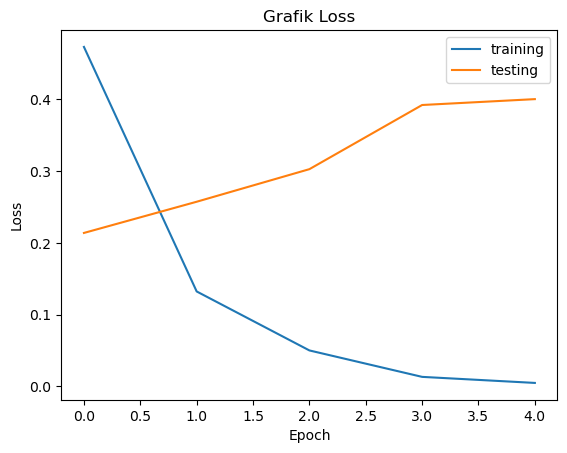

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(metrics['train_loss'], label="training")
plt.plot(metrics['test_loss'], label="testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Grafik Loss')
plt.legend()

Text(0.5, 1.0, 'Grafik Akurasi Testing')

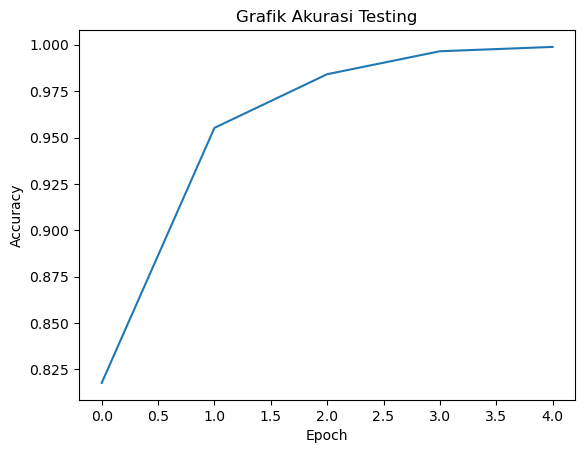

In [12]:
plt.figure()
plt.plot(metrics['train_acc'], label="training")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grafik Akurasi Testing')

Text(0.5, 1.0, 'Grafik F1 Score Testing')

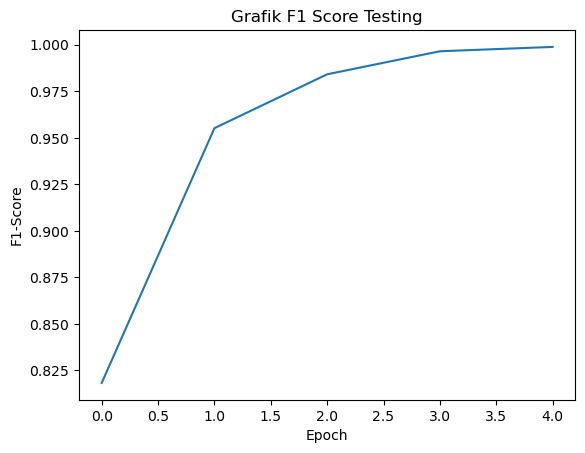

In [13]:
plt.figure()
plt.plot(metrics['train_f1'], label="training")
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Grafik F1 Score Testing')

In [15]:
tabel_hasil = pd.DataFrame(range(1, 6), columns=['ke-'])
tabel_hasil["loss_training"] = metrics["train_loss"]
tabel_hasil["loss_testing"] = metrics["test_loss"]
tabel_hasil["accuracy"] = metrics["test_acc"]
tabel_hasil["F1-Score"] = metrics["test_f1"]
tabel_hasil.head()

tabel_hasil.to_excel("../model/model_IndoBERT.xlsx", index=False)

In [18]:
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

# Load the fine-tuned model
def load_model(model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Tokenize the input text
def tokenize_text(text, tokenizer):
    return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Make predictions
def predict(model, tokenizer, text):
    tokens = tokenize_text(text, tokenizer)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tokens = {key: val.to(device) for key, val in tokens.items()}
    with torch.no_grad():
        outputs = model(**tokens)
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    pred_label = np.argmax(probs, axis=1)
    return pred_label, probs

# Example usage
model_path = "../model/finetuned_IndoBERT.pt"
model = load_model(model_path)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

text = "Pengadilan Agama Garut Sebut Pesan Berantai ‘Nomor Telepon Janda Garut’ Adalah Informasi Hoaks"
pred_label, probs = predict(model, tokenizer, text)
label_map = {0: "Fakta", 1: "Hoax"}
predicted_label = label_map[pred_label[0]]
predicted_prob = probs[0][pred_label[0]]
print(f"Prediction: {predicted_label}, Probability: {predicted_prob:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction: Hoax, Probability: 0.9985
